# COGS 118B - Final Project

# Exploring Different Reinforcement Learning Algorithms for Stock Trading to Optimize Profitability

## Group members

- Ryan Chen
- Nicholas Gao
- Matthew Miyagishima

# Abstract 

Stock trading is full of unpredictability and volatility. Without substantial understanding and experience in trading stocks, it is difficult for a person to trade actively and profit off of stocks. However, mathematical models and intelligent software can do a much better job of learning patterns and capitalizing on them. We explore the performance of value-based and policy-based reinforcement learning algorithms on trading stock data by comparing profits earned by Monte Carlo Q-learning, Monte Carlo policy gradient, and Advantage Actor-Critic on AAPL, TSLA, META, NVDA, and GME stocks from 2014 to 2024. Monte Carlo Policy Gradient agents proved to be the most well-versed at stock trading, achieving 1000%+ in returns with an above one Sharpe ratio and 35% maximum drawdown. Monte Carlo Q Learning performed the worst at 270% returns, 0.60 Sharpe ratio and over 50% maximum drawdown.

# Background 
The stock market is a highly dynamic environment influenced by various factors, making it challenging to develop reliable trading strategies. Traditional rule-based approaches are often too rigid and fail to adapt to changing market conditions. Recently, Reinforcement Learning has emerged as a powerful tool in financial markets due to its ability to dynamically learn trading strategies through interaction with the environment (Yang 2023). RL-based models can optimize buy, sell, and hold decisions by maximizing long-term profitability based on historical market data.  

Several studies have demonstrated the effectiveness of Deep Reinforcement Learning in stock trading. OpenFin Engineering and Columbia University developed a DRL-based framework that outperformed traditional trading strategies, highlighting the potential of policy-based methods in stock trading applications. Deng et al. further explored algorithmic trading using DRL, emphasizing how RL agents can self-adapt to fluctuating market conditions without manual intervention. More recently, Xiao et al. proposed a multi-agent LLM financial trading framework, illustrating how combining large language models with reinforcement learning can enhance decision-making in stock trading environments.  

In this project, we aim to build a stock market trading agent that leverages Markov Decision Processes and applies Monte Carlo Policy Gradient and Advantage Actor-Critic to optimize trading decisions. Unlike traditional machine learning models that rely on fixed historical patterns, our RL agent continuously learns and adapts to real-time market conditions. The agent will be trained and evaluated using historical stock price data, and its performance will be measured through backtesting to assess its ability to generate consistent returns while minimizing risk.


# Problem Statement

The objective of this project is to design a stock market trading agent that interacts with historical stock data and learns to optimize its trading strategy using **Markov Decision Processes (MDPs)**. The problem can be modeled as an MDP with the following components:

- **State Space:** The state provides information on stock prices over the past `window_size` days.
- **Action Space:** The agent can choose one of three actions at each time step:
  - **Buy:** Purchase some quantity of the stock.
  - **Sell:** Sell some quantity of held stocks.
  - **Hold:** Take no action and maintain the current position.
- **Reward Function:** The reward function rewards the agent for making profitable actions on each stock:
  - **Buy:** +5 reward for a valid purchase (based on agent's balance), +2 if agent overestimates number of stocks it can purchase, -5 reward if agent does not have enough money to even purchase one stock
  - **Sell:** +5 for a sell that increases the agent's total portfolio value, -2 if agent loses porfolio value after selling, and -5 for an invalid sell action
  - **Hold:** No reward or penalty
  - **Bonus:** Percentage change in portfolio value * 10

We will train the agent using three reinforcement learning approaches:
1. **Monte Carlo Q-Learning** a model-free method that learns the optimal action at each state.
2. **Monte Carlo Policy Gradient (REINFORCE)** a policy-based on-policy method that simulates entire processes and updates the policy according to the final reward.
3. **A2C** an improvement on REINFORCE that introduces an actor-critic architecture where the actor learns the policy while the critic estimates the value function.

We will evaluate the performance of each agent by looking at the final portfoliio value at the end of the time period. At the same time, we will be comparing their performance against that of the S&P500 across the same period.

# Data

We will use historical stock price data from the following sources:

1. **Yahoo Finance API** ([https://finance.yahoo.com](https://finance.yahoo.com))
   - Provides daily and intraday stock data.
   - Variables: `Date`, `Close`, `Split`.

2. **S&P 500 Historical Data**
   - Used as a benchmark for evaluating the trading agent’s performance.

### Data Preprocessing:
The Yahoo Finance API is a very developed API and has full data over the time period we are considering for the 5 chosen stocks. Thus no data preprocessing is required before using it to train our agents. We simply need to retrieve the relevant stock data by making API calls when initializing the environment.

# Proposed Solution

We propose three different solutions to the stock trading problem. Each of the solution algorithms will train an agent to interact with the environment through buying, selling, and holding on to stocks. These agents will be trained on data on AAPL, TSLA, META, NVDA, and GME stocks from 2014 to 2024 to optimize their profits.

### Monte Carlo Q-Learning

The Monte Carlo Q-Learning algorithm is a value-based on-policy algorithm. In each episode, an action is selected using an epsilon-greedy selection at each state. The entire 10-year stock trading experience is simulated while the state, action, and reward are tracked. At the end of an episode, the tracked states, actions, and rewards are used to update the Q-table at each of those states to favor certain actions over others. The process continues until the agent learns the task well.

Below is the pseudo-code for this algorithm:
```
for each episode:
    initialize the environment
    observe the initial state s

    while episode is not done:
        choose action a using epsilon-greedy policy from Q(s, *)
        take action a, record reward r and next state s'
        store (s, a, r) in episode
        s = s'
    
    G = 0
    for each step (s, a, r) in episode, in reverse order:
        G = gamma * G + r
        if (s, a) is the first occurence in the episode:
            append G to returns(s, a)
            Q(s, a) = average(returns(s, a))
return Q
```

### Monte Carlo Policy Gradient

The Monte Carlo Policy Gradient, or REINFORCE, algorithm is a policy-based on-policy training algorithm. It is similar to MC Q-Learning in that the agent simulates entire episodes of the task based on its policy before updating. However, this algorithm utilizes a neural network to represent its policy, and action selection is over a distribution rather than an epsilon-greedy selection.

Below is the pseudo-code for this algorithm:
```
for each episode:
    initialize the environment
    observe the initial state s
    episode = []

    while episode is not done:
        get distribution from a forward pass
        choose action a using distribution
        take action a, record reward r and next state s'
        store (s, a, r) in episode
        s = s'
    
    G = 0
    for each step (s, a, r) in episode, in reverse order:
        G = gamma * G + r
        theta = theta + alpha * G * gradient(log(policy))
```

### Advantage Actor-Critic

The Advantage Actor-Critic algorithm is a policy-based on-policy training algorithm. It combines both policy gradient and value function estimation where the actor learns the policy while the critic learns to estimate the value of states. This algorithm achieves a more stable learning compared to REINFORCE due to reduced variance in the gradient estimates since it uses advantage for gradient calculations.

Below is the pseudo-code for this algorithm:
```
for each episode:
    initialize the environment
    observe the initial state s
    episode = []

    while not done:
        get action distribution from actor
        choose action a using distribution
        take action a, record reward r and next state s'

        estimate value v of current state
        get value of next state v'
        set td target = r + gamma * v'

        compute advantage A = td target - v

        calculate squared loss for critic and update the critic
        update the actor: theta = theta + alpha * gradient(log(policy) * A)

        s = s'
```

# Evaluation Metrics

The main evaluation metric that we will use is how much the agent grows/shrinks their portfolio percentage-wise over the test period. We will do so by giving the agent a portfolio to start off with at the beginning of the test period and evaluating the portfolio's worth daily throughout testing to measure how well the agent is doing. We believe that this is a good evaluation metric as the main goal of the agent is to maximize the total return through buying, holding, and selling stocks.

A mathematical representation of this metric is:

$$
\text{Total Return} = \frac{V_T - V_0}{V_0} \times 100\%
$$

Where:
- $V_T$ is the value of the portfolio on day T.
- $V_0$ is the value of the portfolio at the beginning.

Another metric we can use to evaluate the agent is Sharpe's Ratio. This is because it quantifies the excess return per unit of risk, offering insight into whether the returns are due to smart investment decisions or excessive risk-taking. A higher Sharpe Ratio indicates that the agent is achieving a superior return relative to the amount of risk assumed with its actions.

The equation for the Sharpe Ratio is:

$$
\text{Sharpe Ratio} = \frac{\bar{R}_p - R_f}{\sigma_p}
$$

Where:
- $\bar{R}_p$ is the average portfolio return over the test period.
- $R_f$ is the risk-free rate.
- $\sigma_p$ is the standard deviation of the portfolio returns.

The last metric we are going to evaluate the agent is the maximum drawdown percentage. This measures the largest percentage drop from a historical peak in the portfolio value to a subsequent trough, highlighting the worst-case scenario during the test period. Maximum drawdown percentage is critical for understanding the downside risk with the agent and helps in evaluating the resilience of the agent's strategy during volatile periods.

The equation for maximum drawdown percentage is:

$$
\text{Max Drawdown \%} = \frac{\text{Peak Value} - \text{Trough Value}}{\text{Peak Value}} \times 100\%
$$

# Results

## Testing all 3 algorithms with 3 stable stocks, 'AAPL', 'META', 'MSFT'

### Monte Carlo Simulations

In [2]:
# Enable auto-reload
%load_ext autoreload
%autoreload 2
from training_env import StockTrainingEnv
from monte_carlo import monte_carlo_train, monte_carlo_eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Set Up Stock Trading Environment
monte_carlo_env_1 = StockTrainingEnv(tickers=['AAPL', 'META', 'MSFT'])

[*********************100%***********************]  3 of 3 completed


In [55]:
# Train the Monte Carlo Agent
monte_carlo_q_table_1 = monte_carlo_train(monte_carlo_env_1)

Monte Carlo Training: 100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


Monte Carlo training complete


In [56]:
# Evaluating the Agent Performance
monte_carlo_evaluation_1 = monte_carlo_eval(monte_carlo_env_1, monte_carlo_q_table_1)

Step: 2515, Balance: 452.55802154541016, Total Value: 37019.31229400635, Shares: {'AAPL': np.float64(12.0), 'META': np.float64(0.0), 'MSFT': np.float64(92.0)}


In [57]:
profit_list = monte_carlo_env_1.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")

Percentage of positive profits: 60.02%


In [58]:
monte_carlo_env_1.get_summary_stats()

{'Initial Value': 10000,
 'Final Value': 36962.570167541504,
 'Total Return (%)': 269.62570167541503,
 'Sharpe Ratio': 0.6401062763872806,
 'Max Drawdown (%)': 50.68403892728972,
 'Total Profits': 26624}

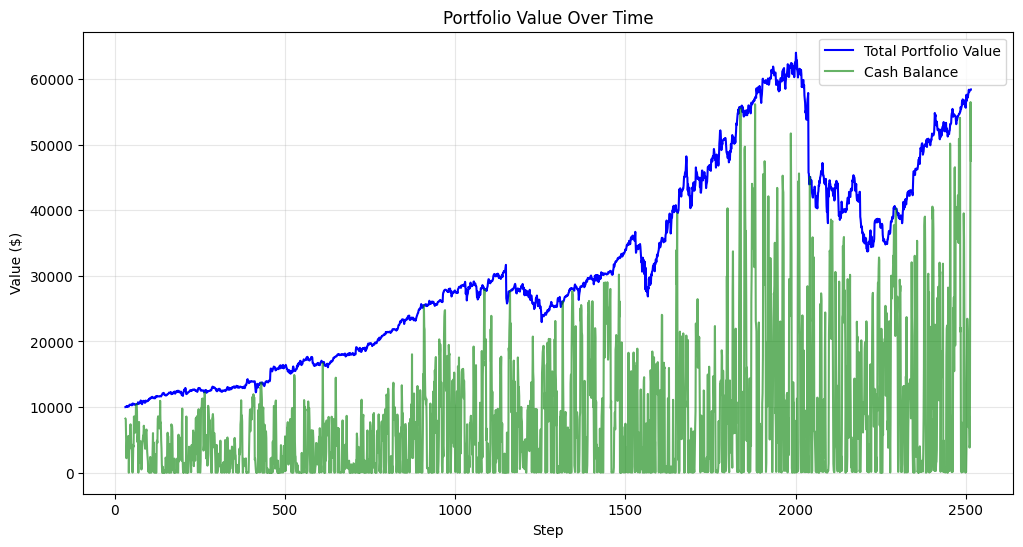

In [51]:
monte_carlo_env_1.plot_portfolio_value()

### Policy Gradient

In [2]:
%load_ext autoreload
%autoreload 2
from policy_gradient import PolicyGradientAgent, policy_gradient_train, policy_gradient_eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
policy_gradient_env_1 = StockTrainingEnv(tickers=['AAPL', 'META', 'MSFT'])

[*********************100%***********************]  3 of 3 completed


In [10]:
# # Define dimensions for the agent
state_dim_1 = policy_gradient_env_1.observation_space.shape[1]
num_tickers_1 = len(policy_gradient_env_1.tickers)
possible_trades_1 = policy_gradient_env_1.possible_trades

In [11]:
# # Create agent
agent_1 = PolicyGradientAgent(policy_gradient_env_1)

In [12]:
# # Train agent
policy_gradient_train(policy_gradient_env_1, agent_1, episodes=1000, gamma=0.99, lr=0.001)

Training Policy Gradient: 100%|██████████| 1000/1000 [59:30<00:00,  3.57s/it, total_reward=68655.04, avg_reward=27.63]


In [13]:
policy_gradient_eval(policy_gradient_env_1, agent_1)

Evaluating Policy Gradient Agent: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s, reward=68655.04]

Step: 2515, Balance: 10.213617324829102, Total Value: 115907.3053226471, Shares: {'AAPL': 300, 'META': 0, 'MSFT': np.float64(157.0)}


In [14]:
profit_list = policy_gradient_env_1.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")

Percentage of positive profits: 0.00%


In [15]:
policy_gradient_env_1.get_summary_stats()

{'Initial Value': 10000,
 'Final Value': 116102.23861122131,
 'Total Return (%)': 1061.022386112213,
 'Sharpe Ratio': 1.0688872848057518,
 'Max Drawdown (%)': 32.35125878569841,
 'Total Profits': 0}

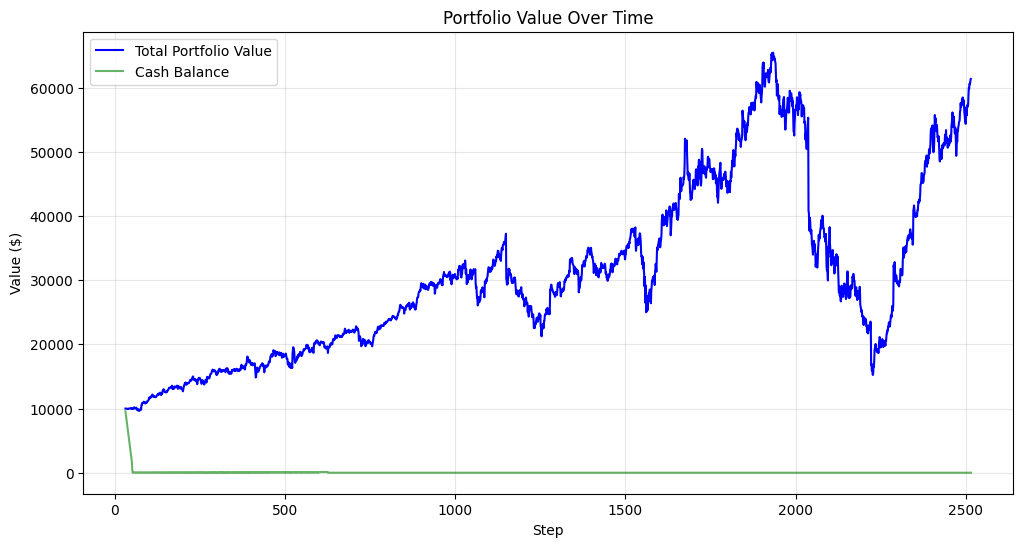

In [15]:
policy_gradient_env_1.plot_portfolio_value()

### A2C

In [32]:
%load_ext autoreload
%autoreload 2
from a2c_model import A2CAgent, a2c_train, a2c_eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
a2c_env_1 = StockTrainingEnv(tickers=['AAPL', 'META', 'MSFT'])

[*********************100%***********************]  3 of 3 completed


In [40]:
# Create Agent and train
a2c_agent_1 = A2CAgent(a2c_env_1)
a2c_agent_train_1 = a2c_train(a2c_env_1, a2c_agent_1)

A2C Training: 100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s, reward=5.33, steps=200]


In [41]:
# Evaluate A2C agent
a2c_agent_eval_1 = a2c_eval(a2c_env_1, a2c_agent_1)

Evaluating A2C Agent: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, reward=70850.51]

Step: 2515, Balance: 2781.0565605163574, Total Value: 81378.97510910034, Shares: {'AAPL': 0, 'META': 0, 'MSFT': 211}


In [42]:
# Calculate the percent of positive profits
profit_list = a2c_env_1.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")
print(profit_list)

Percentage of positive profits: 93.73%
[np.float64(1.176943901447956), np.float64(1.1468288439130987), np.float64(0.9877067434918203), np.float64(0.2781682073225866), np.float64(-0.3272461443008936), np.float64(-0.6124351144102391), np.float64(-1.4815768646623368), np.float64(-1.0109640977343162), np.float64(-0.19621360190625126), np.float64(0.13321990187119326), np.float64(0.11595076734970888), np.float64(-1.092934839743208), np.float64(-1.5134706639769888), np.float64(-1.7137122389028434), np.float64(-0.9892532938748104), np.float64(-1.0975423695634277), np.float64(-1.0457540394853027), np.float64(-0.8008094797483523), np.float64(-0.36578807333236796), np.float64(-0.9163712101785606), np.float64(-0.03681917045813066), np.float64(0.5662935111187863), np.float64(4.596630033486697), np.float64(5.46383042323702), np.float64(5.098673215949631), np.float64(4.165308905215333), np.float64(3.3767244532769283), np.float64(3.9382603026234477), np.float64(4.1473396977273325), np.float64(4.705726

In [43]:
a2c_env_1.get_summary_stats()

{'Initial Value': 10000,
 'Final Value': 81220.11338424683,
 'Total Return (%)': 712.2011338424683,
 'Sharpe Ratio': 0.9338757391547733,
 'Max Drawdown (%)': 36.001334576276875,
 'Total Profits': 50701}

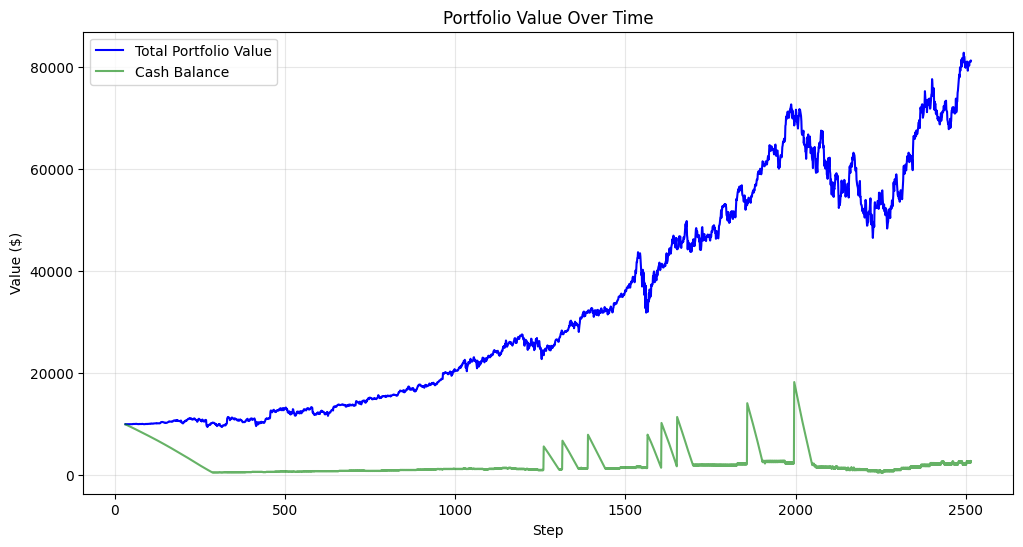

In [44]:
# Visualize the Performance of the Environment
a2c_env_1.plot_portfolio_value()

## Testing all 3 algorithms with 5 stocks and adding 2 volatile stocks, 'NVDA', 'GME'

### Monte Carlo

In [4]:
monte_carlo_env_2 = StockTrainingEnv(tickers=['AAPL', 'META', 'MSFT', 'NVDA', 'GME'])

[*********************100%***********************]  5 of 5 completed


In [5]:
monte_carlo_q_table_2 = monte_carlo_train(monte_carlo_env_2)

Monte Carlo Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]

Monte Carlo training complete


In [6]:
monte_carlo_evaluation_2 = monte_carlo_eval(monte_carlo_env_2, monte_carlo_q_table_2)

Step: 2515, Balance: 368.77541929483414, Total Value: 41782.32477194071, Shares: {'AAPL': np.float64(0.0), 'META': np.float64(0.0), 'MSFT': np.float64(102.0), 'NVDA': np.float64(0.0), 'GME': np.float64(195.0)}


In [7]:
profit_list = monte_carlo_env_2.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")

Percentage of positive profits: 57.54%


In [8]:
monte_carlo_env_2.get_summary_stats()

{'Initial Value': 10000,
 'Final Value': 41810.83508878946,
 'Total Return (%)': 318.10835088789463,
 'Sharpe Ratio': 0.5955424381103767,
 'Max Drawdown (%)': 67.49999500838393,
 'Total Profits': 30922}

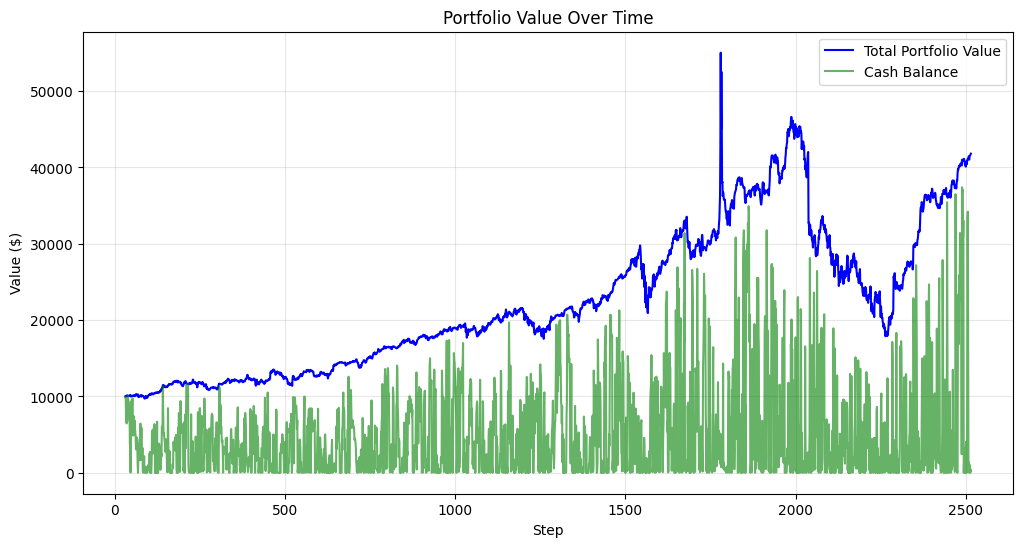

In [9]:
monte_carlo_env_2.plot_portfolio_value()

### Policy Gradient

In [3]:
policy_gradient_env_2 = StockTrainingEnv(tickers=['AAPL', 'META', 'MSFT', 'NVDA', 'GME'])

[*********************100%***********************]  5 of 5 completed


In [5]:
# # Create agent
agent_2 = PolicyGradientAgent(policy_gradient_env_2)

In [6]:
# # Train agent
policy_gradient_train(policy_gradient_env_2, agent_2, episodes=1000, gamma=0.99, lr=0.001)

Training Policy Gradient: 100%|██████████| 1000/1000 [41:45<00:00,  2.51s/it, total_reward=49148.34, avg_reward=19.78]


In [7]:
policy_gradient_eval(policy_gradient_env_2, agent_2)

Evaluating Policy Gradient Agent: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it, reward=49148.34]

Step: 2515, Balance: 3.316926956176758, Total Value: 117444.04156684875, Shares: {'AAPL': 20, 'META': 0, 'MSFT': np.float64(305.0), 'NVDA': 0, 'GME': 0}


In [8]:
profit_list = policy_gradient_env_2.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")

Percentage of positive profits: 50.00%


In [9]:
policy_gradient_env_2.get_summary_stats()

{'Initial Value': 10000,
 'Final Value': 117235.28164863586,
 'Total Return (%)': 1072.3528164863585,
 'Sharpe Ratio': 1.0282082809052178,
 'Max Drawdown (%)': 36.54779475160589,
 'Total Profits': 15}

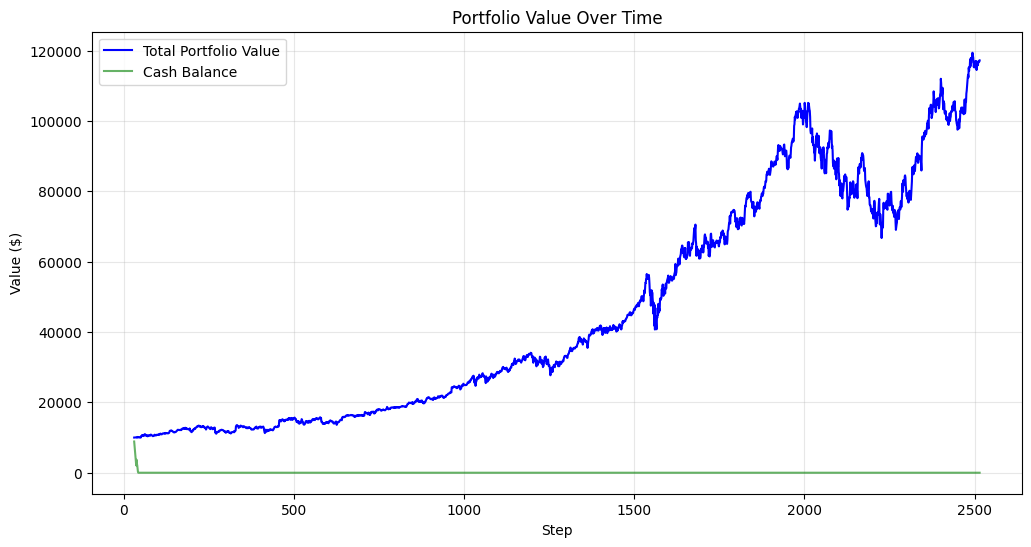

In [10]:
policy_gradient_env_2.plot_portfolio_value()

### A2C

In [11]:
a2c_env_2 = StockTrainingEnv(tickers=['AAPL', 'META', 'MSFT', 'NVDA', 'GME'])

[*********************100%***********************]  5 of 5 completed


In [14]:
# Create Agent and train
a2c_agent_2 = A2CAgent(a2c_env_2)
a2c_agent_train_2 = a2c_train(a2c_env_2, a2c_agent_2)

A2C Training: 100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s, reward=5.33, steps=200]


In [15]:
# Evaluate A2C agent
a2c_agent_eval_2 = a2c_eval(a2c_env_2, a2c_agent_2)

Evaluating A2C Agent: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, reward=70601.74]

Step: 2515, Balance: 6955.940631866455, Total Value: 81083.8353767395, Shares: {'AAPL': 0, 'META': 0, 'MSFT': 199, 'NVDA': 0, 'GME': 0}


In [17]:
# Calculate the percent of positive profits
profit_list = a2c_env_2.profits
positive_profits = [profit for profit in profit_list if profit > 0]
percentage_positive_profits = (len(positive_profits) / len(profit_list)) * 100 if profit_list else 0
print(f"Percentage of positive profits: {percentage_positive_profits:.2f}%")

Percentage of positive profits: 97.64%


In [18]:
a2c_env_2.get_summary_stats()

{'Initial Value': 10000,
 'Final Value': 80934.00844192505,
 'Total Return (%)': 709.3400844192505,
 'Sharpe Ratio': 0.955676230615319,
 'Max Drawdown (%)': 34.852077937741186,
 'Total Profits': 49991}

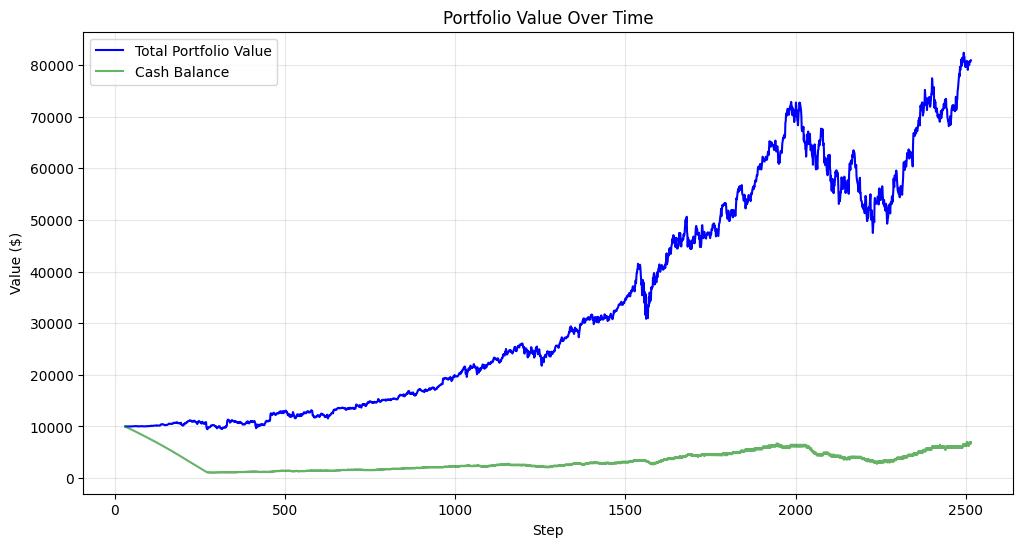

In [19]:
a2c_env_2.plot_portfolio_value()

## Summary of Model Performances

### Final Portfolio Value
Each agent started with a $10,000 balance. We do not take dividends into account.

| Model               | 3 Stocks (AAPL, META, MSFT) | 5 Stocks (AAPL, META, MSFT, NVDA, GME)  |
|---------------------|-----------------------------|-----------------------------------------|
| MC Q Learning       | $36,962.57                  | $41,810.84                              |
| MC Policy Gradient  | $116,102.24                 | $117,235.28                             |
| A2C                 | $81,220.11                  | $80,934.01                              |

In the same time period, if we were to invest the $10,000 in S&P 500, we would grow our portfolio to $26,425.15, without considering dividends.

### Sharpe Ratio

| Model               | 3 Stocks (AAPL, META, MSFT) | 5 Stocks (AAPL, META, MSFT, NVDA, GME)  |
|---------------------|-----------------------------|-----------------------------------------|
| MC Q Learning       | 0.64                        | 0.60                                    |
| MC Policy Gradient  | 1.07                        | 1.03                                    |
| A2C                 | 0.93                        | 0.96                                    |

### Maximum Drawdown Percentage

| Model               | 3 Stocks (AAPL, META, MSFT) | 5 Stocks (AAPL, META, MSFT, NVDA, GME)  |
|---------------------|-----------------------------|-----------------------------------------|
| MC Q Learning       | 50.68%                      | 67.50%                                  |
| MC Policy Gradient  | 32.35%                      | 36.55%                                  |
| A2C                 | 36.00%                      | 34.85%                                  |

# Discussion

### Interpreting the Result

The evaluation results for the stock trading agents indicate that if the agent predominantly held their positions rather than executing frequent trades, it generally outperformed those that sold stocks. This suggests that in a steadily appreciating market, the buy-and-hold strategy might be more effective in our sample space of 3 to 5 stocks.

When looking at the Total Return, the Policy Gradient agent achieved the highest returns in both the 3-stock and 5-stock environments, exceeding 1000% return in each case. In the 3-stock environment, the MC Q Learning agent and the A2C agent performed much worse, achieving only around 270% for MC Q Learning and 710% for A2C. Similarly, in the 5-stock environment, trends on performance of the three models stayed consistent.

The risk-adjusted performance measure, the Sharpe Ratio, was also highest for the Policy Gradient agents. In the 3-stock environment, Policy Gradient had a Sharpe Ratio of 1.07, outperforming Monte Carlo's 0.64 and A2C's 0.93. Furthermore, in the 5-stock environment, Policy Gradient had a Sharpe Ratio of 1.03, which again outperformed Monte Carlo's 0.60 and A2C's 0.96. This higher ratio indicates that the buy-and-hold strategy generated high returns while also achieving relatively lower volatility compared to the more active trading agents.

Lastly, when examining the maximum drawdown, the Policy Gradient agent again showed superior performance with a lower drawdown percentage compared to the other agents in the 3-stock environment, while A2C had a lower maximum drawdown in the 5-stock environment. For the 3-stock environment, Policy Gradient had a maximum drawdown of 32.35%, which is much lower than Monte Carlo's 50.68% and slightly lower than A2C's 36.00%. In the 5-stock environment, Policy Gradient had a maximum drawdown of 36.55%, which again was much lower than Monte Carlo's 67.50% and slightly higher than A2C's 34.85%. These results further indicate that holding stocks rather than selling was a better strategy for overcoming market dips and preserving capital.

---

### Why Agents Performed the Way They Performed

The agents' performance relates directly to the algorithm. In Monte Carlo Q Learning, the algorithm relies on discretized state and action spaces, which is very difficult to achieve in stock trading, as the prices of stock (continuous) dictate the state. Further, we also attempted to discretize the action space by defining buy/sell stock amounts: 1, 5, 10, 25, etc. to remove the need for the model to decide on the specific number to reduce complexity. This helped MC Q Learning as it reduced the size of the Q table. By limiting training and evaluation of the agent to the same stock, however, we were able to generate a Q table that covers all the states that the agent will encounter. Yet, due to the large action space and added complexity as we introduce more stocks (more combinations of actions to take), perhaps 1000 episodes was insufficient for the model to truly learn the best actions at each state due to its reliance on exploration. However, to properly evaluate the performance of the three models, we had to standardize the number of episodes for training and are unable to increase it past 1000 since MC Policy Gradient takes a very long time to train.

An important thing to note on the performance of MC Q Learning is that the agent was much more active than the other two agents in buying and selling stocks, due to learned best actions during training at each specific state. However, this fails to look further ahead and consider long-term benefits, leading to an overall loss of profits and sometimes loss on entire transactions, as highlighted by the high maximum drawdown percentage.

The agent with the next-best performance was A2C. An A2C agent learns both policy and value at each state, done by the actor and the critic. It combines both Q Learning and Policy Gradient to establish a balance between the two techniques. We can see this in action in its performance, as it performs much better than Q Learning but also much worse than Policy Gradient, kind of like taking the average of the two. We believe that, given Policy Gradient's success, a policy-based approach is better for stock trading as value can be volatile as stock prices rise and fall. Thus, we hypothesize that the poor performance of the A2C agent is due to its critic network having trouble estimating values of states.

Finally, the agent that performed the best was Monte Carlo Policy Gradient. This agent operates on a policy instead of trying to estimate the value of current and future states to back their action decisions. The strength in Policy Gradient lies in its ability to directly optimize a continuous policy in a complex environment, which is exactly what the stock market is. Since this policy follows a gradient ascent logic, it can smoothly adjust to find maxima to optimize performance.

---

### Limitations
When making our reinforcement learning-based trading agent, we faced has several limitations. One primary issue is overfitting to historical data, which can lead to an agent that performs well in simulated environments but fails in live trading scenarios due to unfactored market conditions. Since financial markets are inherently non-stationary, the patterns learned by the agent may not generalize well when market dynamics change.  

Another limitation is the computational cost associated with training deep reinforcement learning models. Training an agent using Monte Carlo methods, policy gradients, and A2C requires extensive simulations, making it impractical for real-time decision-making. Moreover, the agent’s sensitivity to hyperparameters, such as learning rates and discount factors, means that small changes in parameter tuning could lead to drastically different results, requiring extensive trial-and-error experimentation.  

Lastly, the lack of transaction costs, slippage, and market impact modeling in our environment introduces unrealistic assumptions. Real-world trading involves fees, bid-ask spreads, and liquidity constraints, which our agent does not currently account for. Future iterations should include these elements to make the simulations more realistic.  

---

### Future Work 
Several potential improvements could be explored to enhance the performance and robustness of our stock trading agent. One major area of development is incorporating additional market indicators and features, such as sentiment analysis from news articles or social media trends, which could help the agent better anticipate market movements. Additionally, exploring hybrid reinforcement learning models that combine policy gradient methods with traditional statistical models could lead to improved decision-making under different market conditions.  

Another important avenue for future research is fine-tuning hyperparameters and experimenting with different architectures for the neural networks in the policy gradient and A2C models. Given that the financial market is highly dynamic, continual learning and transfer learning approaches may also be valuable to allow the agent to adapt to changing market trends over time.  

Finally, risk management strategies could be explicitly incorporated into the reward function. Techniques such as stop-loss mechanisms, portfolio diversification constraints, and adaptive risk-aware reward functions would ensure that the agent does not adopt overly aggressive trading strategies that could lead to significant losses in real-world applications.  

---

### Ethics & Privacy 
The application of reinforcement learning in stock trading raises several ethical and privacy concerns. One of the primary concerns is the potential for market manipulation if such trading agents were deployed at scale. High-frequency trading firms already leverage algorithms to execute trades at speeds that give them unfair advantages over retail investors. If reinforcement learning-based agents gain widespread adoption, they could contribute to increased market volatility and unfair trading advantages.  

Additionally, data privacy and security issues arise when integrating alternative data sources, such as sentiment analysis from social media or private financial transactions. The use of personal financial data without adequate privacy safeguards could lead to ethical violations, particularly if such data is used without consent. Ensuring compliance with data protection regulations is essential when incorporating external data sources into financial models.  

Finally, there is a concern with algorithmic bias. Reinforcement learning models are trained on historical data, meaning they may inherit biases from past trading patterns. If an agent systematically favors certain assets or industries due to biases in the training data, it could contribute to market inefficiencies or unintended economic disparities. Careful monitoring, fairness audits, and transparent reporting of the agent’s decision-making process are crucial to lessen these risks.  

---

### Conclusion

Our exploration of different reinforcement learning agents in stock trading highlighted the superior performance of policy-based agents, particularly the Monte Carlo Policy Gradient, in handling the volatility and complexity of the stock market. While value-based agents, like Monte Carlo Q Learning, struggled to predict future prices due to stock market uncertainty, policy-based agents could better adapt to changing market conditions by directly optimizing trading strategies. The hybrid Advantage Actor-Critic (A2C) model showed intermediate results, benefiting from both value and policy-based methods but not surpassing the pure policy-based approach.

These findings underscore the potential of reinforcement learning for stock trading, though challenges remain, such as computational costs, hyperparameter sensitivity, and the need for real-world considerations like transaction costs. Future work should focus on improving these models by integrating additional data and refining architectures to better align with real-world trading dynamics, including real-time trading.


# References

### 1. Deep Reinforcement Learning for Automated Stock Trading  
Yang, Hongyang, et al. *Deep Reinforcement Learning for Automated Stock Trading: Framework, Design, and Empirical Analysis*. Available at: [https://openfin.engineering.columbia.edu/sites/default/files/content/publications/ensemble.pdf](https://openfin.engineering.columbia.edu/sites/default/files/content/publications/ensemble.pdf).   

### 2. An Application of Deep Reinforcement Learning to Algorithmic Trading  
Théate, Thibaut, et al. *An Application of Deep Reinforcement Learning to Algorithmic Trading*. arXiv, 2020. Available at: [https://arxiv.org/abs/2004.06627](https://arxiv.org/abs/2004.06627).

### 3. TradingAgents: Multi-Agents LLM Financial Trading Framework  
Xiao, Yijia, et al. *TradingAgents: Multi-Agents LLM Financial Trading Framework*. arXiv, 2024. Available at: [https://arxiv.org/abs/2412.20138](https://arxiv.org/abs/2412.20138). 